## Notebook for using DenseNet to tell if the MCA is visible for a slice
Pipeline:
- Import data
- Find volume with the highest cumulative intensity for each patient
- Discard all other volumes
- Perform train, val, test split
- Normalize data
- Initialize model
- Train model
- Test model
- Visualize results
- Use KMeans to extract AIFs

In [2]:
# Imports
import torch
import numpy as np
import pandas as pd
import pydicom as pdc
from utils.datahandling_utils import createImageIndexCSV, get_max_intensity_for_dataset, load_and_prepare_images
from utils.model_utils import train_and_eval
from torch import nn
import os
# Dataleakage from Kmeans
os.environ["OMP_NUM_THREADS"] = "1"

SEED = 41
np.random.seed(SEED)
BATCH_SIZE = 512
EPOCHS = 50
# image_path = "D:/AIF_DCE"
image_path = "D:/iCAT_IMAGES/"
aif_path = "D:/AIFs/AIFs/durable/BorrSci_MR_Data/Output"
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

c:\Users\svenalrik\anaconda3\envs\dev-env2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Import images (paths)
image_data = createImageIndexCSV(image_path)
# Import annotations
mca_labels = pd.read_excel('MCA_labels.xlsx')
mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == 1].index)  # Patient 102(1) contains anomalies
mca_labels = mca_labels.drop(mca_labels[mca_labels['Patient'] == 11].index)  # Patient 112(11) lacks a single pixel array
image_data = image_data[image_data['Patient'].isin(mca_labels['Patient'])]

In [4]:
# Change the label dataframe to be compatible with efficient datahandling
mca_labels = pd.melt(mca_labels, id_vars = ['Patient'], var_name='Slice', value_name='Label').sort_values(['Patient', 'Slice'])

In [5]:
vol_intensities = get_max_intensity_for_dataset(image_data)
train_images, val_images, train_labels, val_labels = load_and_prepare_images(image_data, mca_labels, vol_intensities, SEED, extra_vols = 5)

Added data 1090. Original amount of data 3264
Size training data: 3903. Size test_data: 451.
True labels in training: 1170 of 3903 (30.0%).
True labels in test: 138 of 451 (30.599999999999998%)


In [6]:
from utils.datahandling_utils import SliceIntensityDataset
from torch.utils.data import DataLoader

train_dataset = SliceIntensityDataset(train_images, train_labels, normalize=True, crop=0.7)
val_dataset = SliceIntensityDataset(val_images, val_labels, normalize=True, crop=0.7)
# test_dataset = SliceIntensityDataset(test_images, test_labels, normalize=True, crop=0.7)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# TODO: Implement RayTune/Optima

In [8]:
from models.dense_net_torch import DenseNet
torch.manual_seed(SEED)
model = DenseNet(growth_rate=15, num_init_features = 28, bn_size = 3, drop_rate=0.1, num_classes=1)
print(f"Total number of trainable parameters {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=8e-5)

Total number of trainable parameters 1203409


In [9]:
torch.cuda.empty_cache()
model.load_state_dict(torch.load('Model_crop_128_50.pt'))
model = model.to(device)
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 28, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(28, 45, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(45, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(43, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1):

In [10]:
# losses = train_and_eval(model, train_loader, val_loader, optimizer, criterion, EPOCHS, device, apr=True)

In [11]:
# Saving the model:
# torch.save(model.state_dict(), f"Model_crop_128_{EPOCHS}.pt")

In [12]:
from utils.model_utils import get_model_performance_metrics
train_sorted = get_model_performance_metrics(model, train_images, train_labels, device, True, 0.7)
val_sorted = get_model_performance_metrics(model, val_images, val_labels, device, True, 0.7)

In [13]:
print("Performance on training data:")
print(f"TP: {len(train_sorted[0])} FP: {len(train_sorted[1])} TN: {len(train_sorted[2])} FN: {len(train_sorted[3])}\n")
print("Performance on validation data:")
print(f"TP: {len(val_sorted[0])} FP: {len(val_sorted[1])} TN: {len(val_sorted[2])} FN: {len(val_sorted[3])}\n")

Performance on training data:
TP: 1170 FP: 1 TN: 2732 FN: 0

Performance on validation data:
TP: 136 FP: 4 TN: 309 FN: 2



In [14]:
import matplotlib.pyplot as plt
# Fonts similar to latex document
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.style.use('ggplot')

In [15]:
# import matplotlib.pyplot as plt
# # Fonts similar to latex document
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["mathtext.fontset"] = "dejavuserif"
# plt.style.use('ggplot')
# fig = plt.figure(figsize=(12, 6))
# plt.plot(losses[0][:,0], label='Training loss')
# plt.plot(losses[0][:,1], label='Validation loss')
# plt.xlabel('Epoch')
# plt.minorticks_on()
# plt.ylabel('Loss')
# plt.title('Model loss')
# plt.legend(loc='upper right')

In [16]:
# plt.style.use('ggplot')
# fig = plt.figure(figsize=(12, 6))
# plt.plot(losses[1][:,0], label='Validation accuracy')
# plt.plot(losses[1][:,1], label='Validation precision')
# plt.plot(losses[1][:,2], label='Validation recall')
# plt.xlabel('Epoch')
# plt.ylabel('Metric')
# plt.minorticks_on()
# plt.title('Accuracy, Precision, Recall')
# plt.legend(loc='lower right')

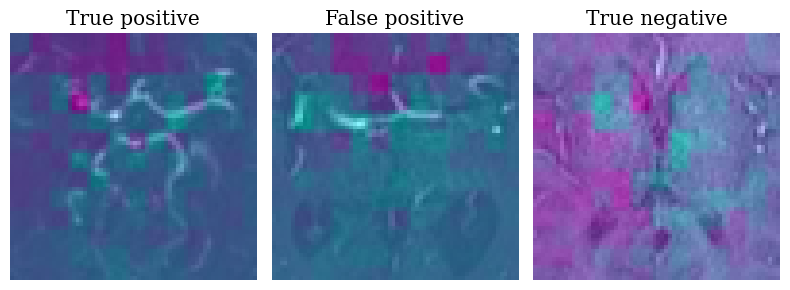

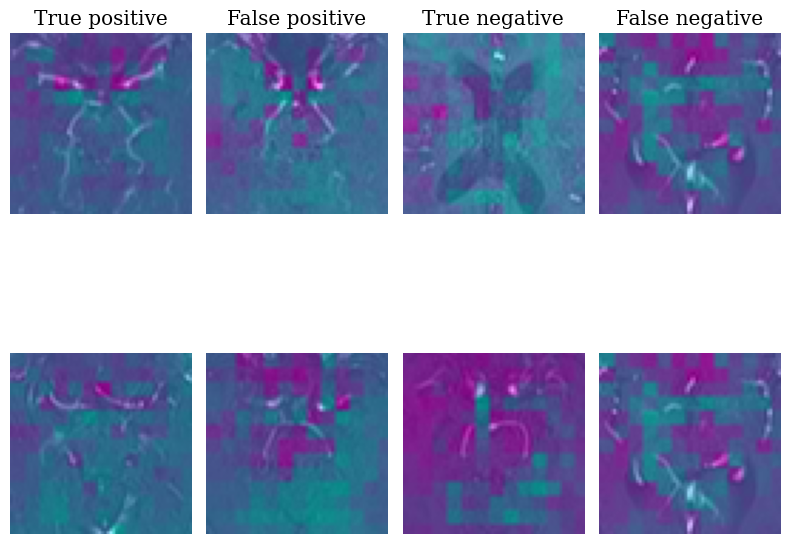

In [17]:
from utils.visualization_utils import display_predictions
display_predictions(train_sorted, model, device, True, True, 0.7)
display_predictions(val_sorted, model, device, True, True, 0.7)

In [18]:
def NLC_s2c(S, TR, FA):
    FA = FA*(np.pi/180)
    r1 = 4.5
    T_10 = 1.4
    S_0 = np.mean(S[:5])
    E_10 = np.exp(-TR/T_10)
    B = (1-E_10)/(1-E_10*np.cos(FA))
    A = np.nan_to_num(B*S/S_0)
    R1 = np.nan_to_num(-1/TR * np.log((1-A)/(1-A*np.cos(FA))))
    return R1

def s2c(S, TR, FA):
    FA = FA*(np.pi/180)
    r1 = 4.5
    T_10 = 1.4
    S_0 = np.mean(S[:5, :, :], axis=0)
    A = (1-np.cos(FA)*np.exp(-TR))/(1-np.exp(-TR))
    T_1 = np.nan_to_num(-TR/(np.log(A-S/S_0)-np.log(A-(S/S_0)*np.cos(FA))))
    C = np.nan_to_num(1/r1*(1/T_1 - 1/T_10))
    return C

def baseline_s2c(S, TR, FA):
        return S/10 - 4.48

In [19]:
from utils.model_utils import eval_curves
curve_evals, _, _ = eval_curves(model, image_data, vol_intensities, device, SEED, crop= 0.7, visualize=False, signal_to_concentration=NLC_s2c)

Patient 2


d:\dev\Masterthesis\models\mouridsen.py:21: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


AttributeError: 'NoneType' object has no attribute 'split'

array([[<AxesSubplot: title={'center': 'MAE'}>,
        <AxesSubplot: title={'center': 'RMSE'}>],
       [<AxesSubplot: title={'center': 'R2'}>, <AxesSubplot: >]],
      dtype=object)

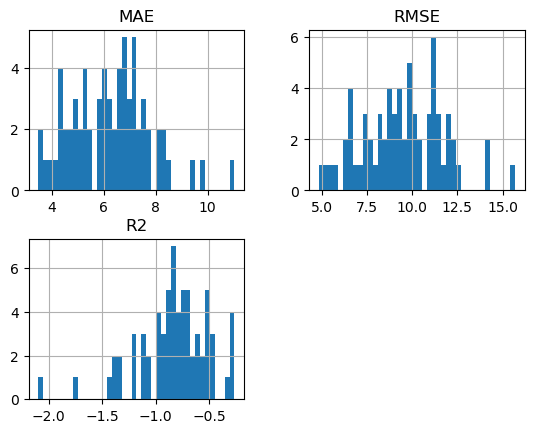

In [ ]:
curve_evals.hist(column= ['MAE', 'RMSE', 'R2'], bins=40)

In [ ]:
print("Patient with the highest R2:")
print(curve_evals.loc[curve_evals['R2'].idxmin()])
print("\nPatient with the lowest MAE:")
print(curve_evals.loc[curve_evals['MAE'].idxmax()])
print("\nPatient with the lowest RMSE")
print(curve_evals.loc[curve_evals['RMSE'].idxmax()])

Patient with the highest R2:
Patient    69.000000
Slice      20.000000
MAE         5.972754
RMSE        7.162594
R2         -2.097234
Name: 66, dtype: float64

Patient with the lowest MAE:
Patient     3.000000
Slice      21.000000
MAE        11.033093
RMSE       15.674967
R2         -0.962003
Name: 1, dtype: float64

Patient with the lowest RMSE
Patient     3.000000
Slice      21.000000
MAE        11.033093
RMSE       15.674967
R2         -0.962003
Name: 1, dtype: float64


Patient 3


d:\dev\Masterthesis\models\mouridsen.py:21: RuntimeWarning: invalid value encountered in divide
  standardized_curves = slices/areas_stacked


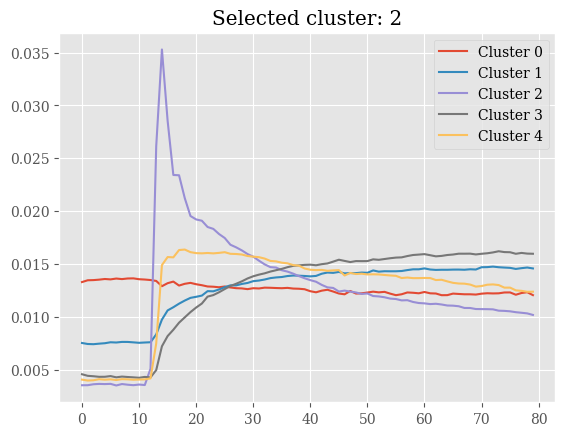

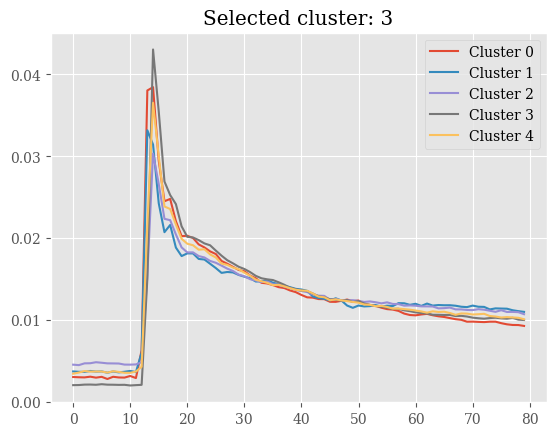

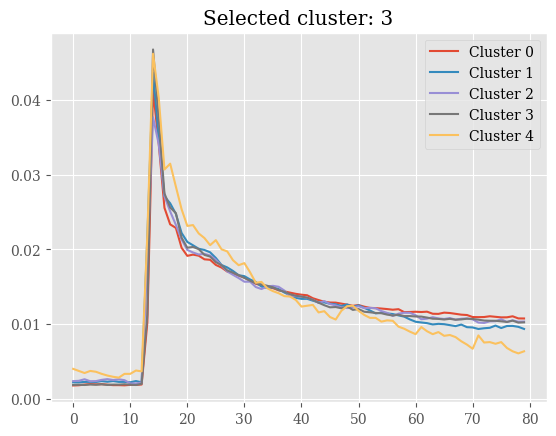

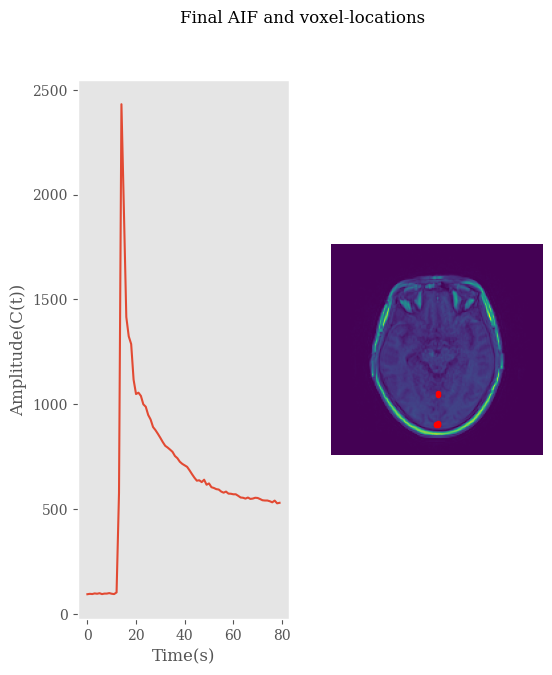

In [ ]:
# Single curve
def s2r(S, TR, FA):
    return S/10 - 4.48
from utils.model_utils import eval_curves
single_data = image_data[image_data['Patient'] == 3]
pred_curve, extractions, label_curves = eval_curves(model, single_data, vol_intensities, device, SEED, crop=0.7, visualize=True, signal_to_concentration=s2r)

In [20]:
fig = plt.figure()
for p, s in extractions.keys():
    plt.plot(extractions[(p,s)], color="red", label="Predicted")
    print(np.argmax(extractions[(p,s)]))
    plt.plot(label_curves[(p,s)], color="blue", label="Actual")
plt.legend(loc="upper right")
plt.xlabel("Timestep")
plt.ylabel("Amplitude")
plt.title("Predicted vs. actual AIF")

NameError: name 'extractions' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
# Make a dashed line indicating the shift of the peaks.